# Fake News Classification Data

This data was taken from the Kaggle dataset linked below. It consists of 2 datasets of news stories (totalling around 45,000 articles) - one from real,reputable news sources and the other from 'fake news' sources.

The objective is to correctly classify whether an article is fake or not, by training classification models on the target variable (defined by which dataset the article came from).

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [70]:
import pandas as pd
import numpy as np
import math
import datetime
import calendar
import string
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import chart_studio.plotly as py

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
import nltk
from nltk.corpus import stopwords
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
fake_news=pd.read_csv('Fake.csv')
fake_news['IsFake']=1

real_news=pd.read_csv('True.csv')
real_news['IsFake']=0

news_data=real_news.append(fake_news)
news_data.head()

,title,text,subject,date,IsFake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [3]:
news_data['IsFake'].value_counts()

1    23481
0    21417
Name: IsFake, dtype: int64

It seems like the dataset is  split relatively evenly between fake and real news - we shouldn't have to do any resampling as the classes are balanced

# Data Cleaning

#### Remove duplicates

In [3]:
initial_no=news_data.shape[0]
print("Number of records: ",initial_no)
news_data.drop_duplicates(inplace=True)
print(initial_no-news_data.shape[0],"records with identical data removed")
print("Number of records after removing duplicates: ",news_data.shape[0])

Number of records:  44898
209 records with identical data removed
Number of records after removing duplicates:  44689


#### Check if there are any exact duplicate articles that are flagged as fake and real

In [5]:
news_data.groupby("text").nunique()[["IsFake"]].sort_values('IsFake',ascending=False)

IsFake
text                                                      
                                                         2
TAIPEI (Reuters) - Taiwan s government said on ...       1
TAIPEI (Reuters) - Taiwan said its environment ...       1
TAIPEI (Reuters) - Taiwan will allow visa-free ...       1
TAIPEI (Reuters) - Taiwan will increase future ...       1
...                                                    ...
HARARE (Reuters) - Zimbabwe s ruling ZANU-PF pa...       1
HARARE (Reuters) - Zimbabwe s ruling ZANU-PF pa...       1
HARARE (Reuters) - Zimbabwe s ruling party accu...       1
HARARE (Reuters) - Zimbabwe s ruling party will...       1
youngers these days are becoming so moist pic.t...       1

[38646 rows x 1 columns]

In [6]:
news_data.groupby("title").nunique()[["IsFake"]].sort_values('IsFake',ascending=False)

,IsFake
title,
\r\r\r\r\r\r\r\nDonald Trump Gets His A** Handed To Him By A 10-Year-Old Girl (VIDEO)\r\r\r\r\r\r\r\n,1
Pentagon notified U.S. Congress of $593 million military sale to Nigeria,1
Pentagon revises law of war manual after criticism of press treatment,1
Pentagon says diplomatic tension with Turkey not affecting military operations,1
Pentagon says fourth U.S. soldier killed in Niger ambush,1
...,...
California Democrats propose series of infrastructure bills,1
California Governor Brown pushes big water project amid drought,1
"California Governor Brown vows to fight Trump, calls for civility",1


The only text with both real and fake flagged articles is a blank space - we will look into these. There are no titles that appear in both the fake and real datasets.

#### Check if there are any duplicate articles or titles

In [41]:
duplicate_articles=pd.DataFrame(news_data['text'].value_counts().loc[lambda x : x!=1])
print(len(duplicate_articles)," articles appear multiple times")
print(duplicate_articles['text'].sum()-len(duplicate_articles)," articles are duplicates")
duplicate_articles.head(10)

4947  articles appear multiple times
6043  articles are duplicates


text
                                                     627
Because there wouldn t be any outrage over a  w...     4
Things didn t go as well as Nicholle had hoped ...     4
On September 15, Hillary  apparently  held a ra...     4
Enjoy:                                                 4
                                                       4
AP News  The regulars amble in before dawn and ...     4
Why should Barack Obama bother with the courts?...     3
This is the best explanation of why Obama and t...     3
Fox News Channel s Jeanine Pirro went after the...     3

In [66]:
duplicate_titles=pd.DataFrame(news_data['title'].value_counts().loc[lambda x : x!=1])
print(len(duplicate_titles)," titles appear multiple times")
print(duplicate_titles['title'].sum()-len(duplicate_titles)," titles are duplicates")
duplicate_titles.head(10)

5445  titles appear multiple times
5960  titles are duplicates


,title
Factbox: Trump fills top jobs for his administration,14
Factbox: Contenders for senior jobs in Trump's administration,8
MEDIA IGNORES Time That Bill Clinton FIRED His FBI Director On Day Before Vince Foster Was Found Dead,6
Factbox: International reaction to arrest of Reuters reporters in Myanmar,6
"Factbox: Contenders, picks for key jobs in Trump's administration",5
Factbox: Contenders for key jobs in Trump's administration,4
FORMER FBI ASST DIRECTOR: “Jim Comey ‘Danced With The Devil’…I’m Glad He’s Gone” [VIDEO],4
Timeline: Zika's origin and global spread,4
Factbox: Why the Zika virus is causing alarm,4
ELEMENTARY SCHOOL PLANS ‘BLACKS ONLY’ FIELD TRIP TO COLLEGE FOR THIRD GRADERS,4


There are a lot of duplicates, and also over 600 'duplicate' records where the article was a blank text. 
Let's separate these out and look at the genuine duplicates.

In [348]:
news_data[news_data["text"].str.strip()=='']

,title,text,subject,date,IsFake,textlengthwords,titlelengthwords,VideoStoryOrLink,Datetime,Year,titlelength,textlength,text_percent_punct,title_percent_punct,text_excl,title_excl,text_incaps,title_incaps,news,news_clean
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",0,0,4,0,2016-06-16,2016,30,1,0.0,0.037037,0,0,0.0,0.000000,Graphic: Supreme Court roundup,graphic supreme court roundup
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017",1,0,15,0,2017-05-10,2017,83,1,0.0,0.028986,0,0,0.0,0.200000,TAKE OUR POLL: Who Do You Think President Trum...,take poll think president trump pick replace j...
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017",1,0,19,1,2017-04-26,2017,116,1,0.0,0.040816,0,1,0.0,0.105263,Joe Scarborough BERATES Mika Brzezinski Over “...,joe scarborough berates mika brzezinski cheap ...
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",1,0,13,1,2017-04-06,2017,86,1,0.0,0.054054,0,0,0.0,0.230769,WATCH TUCKER CARLSON Scorch Sanctuary City May...,watch tucker carlson scorch sanctuary city may...
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017",1,0,13,1,2017-04-02,2017,82,1,0.0,0.042857,0,0,0.0,0.307692,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,mayor sanctuary city trump trying make us fugi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015",1,0,14,0,2015-04-27,2015,93,1,0.0,0.012500,0,0,0.0,1.000000,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,baltimore burns maryland governor brings natio...
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015",1,0,8,1,2015-04-25,2015,59,1,0.0,0.019231,0,0,0.0,1.000000,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,full video blockbuster investigation clinton c...
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015",1,0,11,1,2015-04-25,2015,82,1,0.0,0.041667,0,0,0.0,1.000000,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,video hillary clinton religious beliefs must c...
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015",1,0,12,1,2015-04-14,2015,91,1,0.0,0.037500,0,0,0.0,1.000000,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,videoice protecting obama release names crimin...


In [4]:
NonBlankArticles =news_data[news_data["text"].apply(lambda x: x.strip())!=""]
BlankTextArticles=news_data[news_data["text"].apply(lambda x: x.strip())==""]

print(len(NonBlankArticles)," articles with text")
print(len(BlankTextArticles)," articles with a blank text")

44058  articles with text
631  articles with a blank text


In [5]:
initial_no=NonBlankArticles.shape[0]
print("Number of records: ",initial_no)

NonBlankArticles.sort_values(['title','text','date'],ascending=[True,True,True])
NonBlankArticles.drop_duplicates(subset=['title','text'], keep="last",inplace=True) 
print(initial_no-NonBlankArticles.shape[0]," duplicate articles removed")

print("Number of records after removing duplicates: ",NonBlankArticles.shape[0])

Number of records:  44058
5400  duplicate articles removed
Number of records after removing duplicates:  38658


C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [69]:
duplicate_articles=pd.DataFrame(NonBlankArticles['text'].value_counts().loc[lambda x : x!=1])
print(len(duplicate_articles)," articles appear multiple times")
print(duplicate_articles['text'].sum()-len(duplicate_articles)," articles are duplicates")
duplicate_articles.head(10)

14  articles appear multiple times
14  articles are duplicates


text
WASHINGTON (Reuters) - U.S. Representative Mark...     2
She burst on the scene last August when she ups...     2
Watch:                                                 2
LONDON (Reuters) - Back from Brussels with a ha...     2
On September 15, Hillary  apparently  held a ra...     2
BEIRUT (Reuters) - The battle for the city of R...     2
AP News  The regulars amble in before dawn and ...     2
Things didn t go as well as Nicholle had hoped ...     2
Our FBI Director has testified once before in r...     2
WASHINGTON (Reuters) - President Donald Trump’s...     2

In [70]:
duplicate_titles=pd.DataFrame(NonBlankArticles['title'].value_counts().loc[lambda x : x!=1])
print(len(duplicate_titles)," titles appear multiple times")
print(duplicate_titles['title'].sum()-len(duplicate_titles)," titles are duplicates")
duplicate_titles.head(10)

340  titles appear multiple times
376  titles are duplicates


,title
Factbox: Trump fills top jobs for his administration,14
Factbox: Contenders for senior jobs in Trump's administration,8
Factbox: International reaction to arrest of Reuters reporters in Myanmar,6
"Factbox: Contenders, picks for key jobs in Trump's administration",5
Factbox: Contenders for key jobs in Trump's administration,4
Timeline: Zika's origin and global spread,4
"Contenders, picks for key jobs in Trump's administration",3
Factbox: Why the Zika virus is causing alarm,3
Factbox: Countdown to Brexit breakthrough?,3
Factbox: The race to the U.S. presidential nominations: How delegates are selected,3


#### Articles with blank text

Let's look at the length of the titles of these articles - it's possible the body of text has got shifted into this column.

In [6]:
BlankTextArticles["titlelengthwords"]=BlankTextArticles["title"].apply(lambda x: len(x.split()))
BlankTextArticles.sort_values('titlelengthwords',ascending=False).head(100)

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,title,text,subject,date,IsFake,titlelengthwords
11922,LEFTIST FREAKS OPENLY CALL For Non-Peaceful In...,,politics,"Jan 13, 2017",1,34
19316,LEFTIST FREAKS OPENLY CALL For Non-Peaceful In...,,left-news,"Jan 13, 2017",1,34
11465,A MUST WATCH! JUDGE NAPOLITANO: “For the first...,,politics,"Mar 8, 2017",1,33
16212,A MUST WATCH! JUDGE NAPOLITANO: “For the first...,,Government News,"Mar 8, 2017",1,33
11343,POLITICAL HACK DIANNE FEINSTEIN Makes a Fool o...,,politics,"Mar 21, 2017",1,31
...,...,...,...,...,...,...
12286,MARCO RUBIO Weighs In On Castro’s Death: “He d...,,politics,"Nov 27, 2016",1,19
21787,(VIDEO) PAM GELLER HAMMERS CNN HOST: “Did Chri...,,left-news,"May 4, 2015",1,19
11305,INTEL WHISTLEBLOWER: Trump was likely spied on...,,politics,"Mar 25, 2017",1,18
19656,LOL! LIBERALS ACCUSE MAN Of Voter Intimidation...,,left-news,"Nov 9, 2016",1,18


None of the titles seem to have enough words to be the actual body of the article - although some of them are quite long for a headline!

Now let's check what's in the text of some of these titles

In [73]:
display(BlankTextArticles['title'].unique())

array(['Graphic: Supreme Court roundup',
       'TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?',
       'Joe Scarborough BERATES Mika Brzezinski Over “Cheap Shot” At Ivanka Trump: “You don’t have to be so snotty!” [VIDEO]',
       'WATCH TUCKER CARLSON Scorch Sanctuary City Mayor: “Don’t you believe in laws?” [Video]',
       'MAYOR OF SANCTUARY CITY: Trump Trying To Make Us “Fugitive Slave Catchers” [Video]',
       'SHOCKER: Public School Turns Computer Lab Into Mosque…Bars Non-Muslim Students [Video]',
       'BOOM! SEAN SPICER: “Trump Sold Hotels In Russia While Hillary Clinton Sold Uranium”',
       'MICHAEL FLYNN’S LAWYER Releases Statement Scorching “Highly Politicized Witch Hunt”',
       'ROB SCHNEIDER Nails The Russia Conspiracy Theorists In One Hysterical Tweet',
       'TREY GOWDY ON SPYING ON AMERICAN CITIZENS…Like President Trump! [Video]',
       'SEAN SPICER CALLS OUT Race Baiting Journalist: “Stop Shaking Your Head Again” [Video]',

Nearly all these "articles" have titles containing [VIDEO]. It seems as these aren't really "articles" at all, just videos with a title. 

These type of records have also almost entirely come from the fake news set - suggesting there might be value in separating them out and handling them differently, or removing them entirely

In [7]:
def FindVideo(title):
    if "VIDEO" in title.upper():
        return 1
    else:
        return 0

In [8]:
BlankTextArticles['IsVideo']=BlankTextArticles["title"].apply(lambda x: FindVideo(x))
BlankTextArticles['IsVideo'].value_counts()

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    523
0    108
Name: IsVideo, dtype: int64

In [9]:
BlankTextArticles['IsFake'].value_counts()

1    630
0      1
Name: IsFake, dtype: int64

In [44]:
display(BlankTextArticles[BlankTextArticles['IsVideo']==0]['title'].unique())

array(['Graphic: Supreme Court roundup',
       'TAKE OUR POLL: Who Do You Think President Trump Should Pick To Replace James Comey?',
       'BOOM! SEAN SPICER: “Trump Sold Hotels In Russia While Hillary Clinton Sold Uranium”',
       'MICHAEL FLYNN’S LAWYER Releases Statement Scorching “Highly Politicized Witch Hunt”',
       'ROB SCHNEIDER Nails The Russia Conspiracy Theorists In One Hysterical Tweet',
       'FAKE NEWS! MAXINE WATERS and JOY REID Make Outrageous Claims Against President Trump “Will make sure poor people aren’t getting too much from government”',
       'SHOCKER! CNN POLITICAL DIRECTOR On Trump’s First 50 Days: ‘The business community could not be more enthusiastic’',
       'VP PENCE OUTRAGED! The Associated Press Publishes His Wife’s Private Email Address',
       'ADORABLE MELANIA TRUMP Fan Dressed Up for School Project…NAILS The First Lady’s Inauguration Look',
       'LIVE FEED: PRESIDENT TRUMP Speaks At CPAC – 10:00 a.m. EST',
       'BOOM! This One Picture Wi

#### See if any articles have a blank title

In [43]:
BlankTitleArticles=news_data[news_data["title"].apply(lambda x: x.strip())==""]
print(len(BlankTitleArticles)," articles have a blank title")
BlankTitleArticles.head()

0  articles have a blank title


,title,text,subject,date,IsFake


#### Merged blank text articles back in with the other deduped articles

In [16]:
news_data=pd.concat([NonBlankArticles,BlankTextArticles.drop(['IsVideo','titlelengthwords'],axis=1)])
news_data.head()

,title,text,subject,date,IsFake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


#### Check if there are any other records that have very short text length - what kind of "articles" are these?

In [17]:
news_data["textlengthwords"]=news_data["text"].apply(lambda x: len(x.split()))
news_data["titlelengthwords"]=news_data["title"].apply(lambda x: len(x.split()))

news_data[(news_data['textlengthwords']>0) & (news_data['textlengthwords'] <=20)].sort_values('textlengthwords').head(10)

,title,text,subject,date,IsFake,textlengthwords,titlelengthwords
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,1,1,1
19252,WATCH! TRUMP SUPPORTER “BIG JOE” Surrounded By...,https://www.youtube.com/watch?v=IPqrimR8GWw,left-news,"Jan 24, 2017",1,1,18
19262,WOW! CHUCK TODD Goes After Nasty Chuck Schumer...,https://www.youtube.com/watch?v=EOr9fwoc_mo,left-news,"Jan 22, 2017",1,1,16
19272,"“THANK YOU BABY”…YES, FEMINISTS WILL GO NUTS: ...",https://www.youtube.com/watch?v=9LNyx_DWzzA,left-news,"Jan 21, 2017",1,1,21
19376,BREAKING: DEMOCRAT Makes Shocking Statement Re...,https://www.youtube.com/watch?v=IioEIUmawRo,left-news,"Dec 31, 2016",1,1,11
19400,OUCH! Paul Joseph Watson DESTROYS MTV’s Racist...,Enjoy,left-news,"Dec 26, 2016",1,1,35
19401,GIVE ‘EM HELL JESSE: Shouldn’t you Democrats s...,https://www.youtube.com/watch?v=wYdX071Nlow,left-news,"Dec 26, 2016",1,1,15
19403,‘YOU’RE A SEXIST PIG!’ FEMINIST BATTLES Tucker...,https://www.youtube.com/watch?v=YeDU6dCR9tA,left-news,"Dec 24, 2016",1,1,11
19495,UNREAL! CNN PANEL Laughs And Mocks Dr. Ben Car...,https://www.youtube.com/watch?v=_FNt3ns_EGA,left-news,"Dec 6, 2016",1,1,13
19235,TRUMP’S BRILLIANT Director Of Communications O...,Watch:,left-news,"Jan 28, 2017",1,1,16


Many of these seem to just be links to YouTube or other sites, and again most seem to be fake news

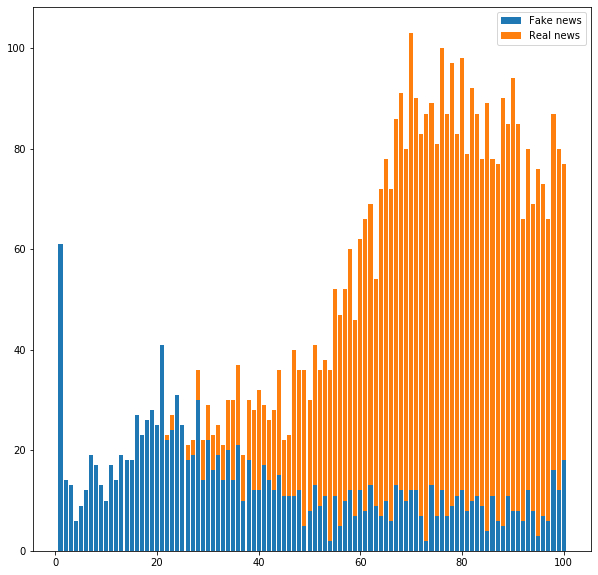

In [81]:
shortarticles=news_data[(news_data['textlengthwords']>=1) & (news_data['textlengthwords'] <=100)]
shortsdist=shortarticles.groupby(['textlengthwords', 'IsFake']).size().unstack()

plt.figure(figsize=(10, 10))

plt.bar(shortsdist.index,shortsdist[1],width=0.8,label="Fake news")
plt.bar(shortsdist.index,shortsdist[0],width=0.8,bottom=shortsdist[1],label="Real news")
plt.legend()


We can see that all the articles with 20 words or less are all fake news - and there are quite a few that are just one word

In [82]:
news_data[news_data['textlengthwords']==1]['text'].unique()

array(['https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/',
       'https://www.youtube.com/watch?v=cJZFepSvxzM',
       'https://www.youtube.com/watch?v=-7Tn4gi_Os8',
       'https://www.youtube.com/watch?v=n9tfNMQpYWU',
       'https://www.youtube.com/watch?v=uCS4RB9G13M',
       'https://www.youtube.com/watch?v=ISm-p8e-D7I',
       'https://www.youtube.com/watch?v=rUr8pYr5AXs',
       'https://www.youtube.com/watch?v=gqxwF-TeYas',
       'https://www.youtube.com/watch?v=aHkNzBRqPCE',
       'https://www.youtube.com/watch?v=RRPSCqkAJgk',
       'https://www.youtube.com/watch?v=tY0ApLE6dns',
       'https://www.youtube.com/watch?v=sMHGkzrwzKg',
       'https://www.youtube.com/watch?v=6VN1maBEKIk',
       'https://www.youtube.com/watch?v=0cVugq2GbBk',
       'https://www.youtube.com/watch?v=CCr0qvehJIk',
       'https://www.youtube.com/watch?v=HXJZbPAf0sk',
       'https://www.youtube.com/wa

So a lot of these one word articles are just more links to videos, or links to another site. We can flag these as such, along with the video links we identified earlier

In [18]:
def FlagVideoOrLink(Title,Text):
    if Text.strip()=="" and "VIDEO" in Title.upper():
        return 1
    elif len(Text.split())==1 and Text.startswith('https://'):
        return 1
    else:
        return 0

In [19]:
news_data["VideoStoryOrLink"]=news_data.apply(lambda x: FlagVideoOrLink(x['title'],x['text']),axis=1)

news_data[news_data["VideoStoryOrLink"]==1].head()

,title,text,subject,date,IsFake,textlengthwords,titlelengthwords,VideoStoryOrLink
9358,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,1,1,1,1
11251,MELANIA TRUMP GIVES POWERFUL SPEECH to Honor ‘...,https://www.youtube.com/watch?v=cJZFepSvxzM,politics,"Mar 30, 2017",1,1,16,1
11286,TERRORISM EXPERT SEBASTIAN GORKA On What Next ...,https://www.youtube.com/watch?v=-7Tn4gi_Os8,politics,"Mar 26, 2017",1,1,12,1
11492,Judge Jeanine Gets to The Bottom of “Towergate...,https://www.youtube.com/watch?v=n9tfNMQpYWU,politics,"Mar 5, 2017",1,1,9,1
11626,BOOM! TOMI LARHEN Destroys The Idiotic “Day Wi...,https://www.youtube.com/watch?v=uCS4RB9G13M,politics,"Feb 18, 2017",1,1,14,1


#### Check subjects

This may be useful information to include in our model alongside the text, for example if certain categories are more likely to be fake

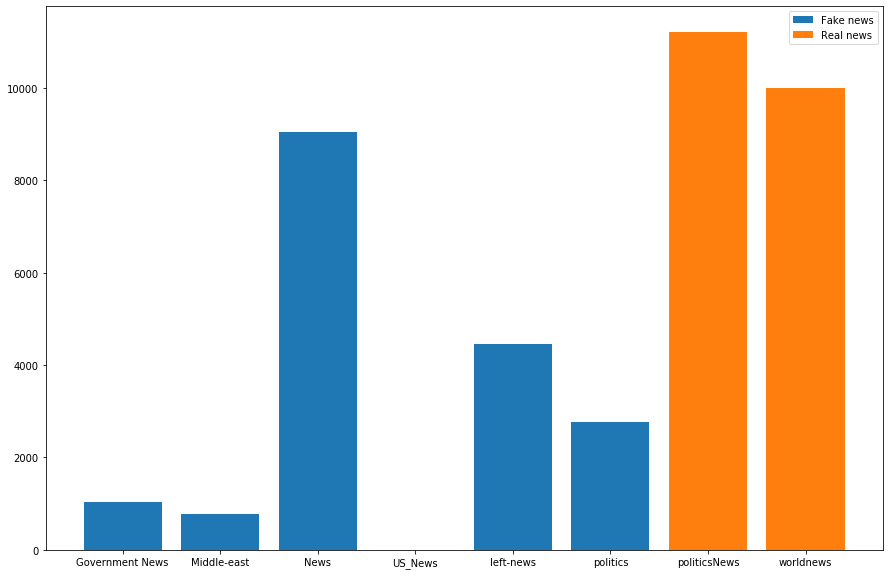

In [85]:
subjects=news_data.groupby(['subject', 'IsFake']).size().unstack()

plt.figure(figsize=(15, 10))

plt.bar(subjects.index,subjects[1],width=0.8,label="Fake news")
plt.bar(subjects.index,subjects[0],width=0.8,label="Real news")
plt.legend()

There are obviously just different labels that have been used for the two datasets, so these labels don't really give us any useful information

#### Date column

This may be useful information to include in our model alongside the text.
For example we may be able to observe seasonality in the frequency of fake news, or if there was particular proliferation of this around the US election.

Are any dates missing?

In [90]:
news_data[news_data["date"].apply(lambda x: x.strip())==""]

,title,text,subject,date,IsFake,textlengthwords,titlelengthwords,IsVideoStory


In [87]:
print(news_data['date'].nunique())
print(news_data['date'].min())          
print(news_data['date'].max())   

2397
14-Feb-18
https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg


We can see from the above that the date column has some values which shouldn't be there

In [120]:
news_data.sort_values('date',ascending=False).head()

,title,text,subject,date,IsFake,textlengthwords,titlelengthwords,IsVideoStory
17432,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,0
15839,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,0
21869,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,0
17433,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,0
15840,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,1,1,1,0


In [88]:
news_data[news_data["IsFake"]==0]["date"].apply(lambda x: x.split()[0]).value_counts()

November     3711
October      3489
September    3408
December     2838
March        1168
February     1017
January       994
June          973
August        915
April         911
May           898
July          875
Name: date, dtype: int64

In [89]:
news_data[news_data["IsFake"]==1]["date"].apply(lambda x: x.split()[0]).value_counts()

May                                                                                                                                                      1676
January                                                                                                                                                  1192
March                                                                                                                                                    1121
February                                                                                                                                                 1091
April                                                                                                                                                     920
Oct                                                                                                                                                       830
June                                                

It seems like the unexpected date values come from the fake news dataset. The code below will put standardize all date stamps to the same format, if some valid date is present

In [20]:
import calendar
test='February 28, 2021'

monthdict = {"January": "Jan",
             "February": "Feb",
             "March": "Mar",
             "April": "Apr",
             "June": "Jun",
             "July": "Jul",
             "August": "Aug",
             "September": "Sep",
             "October": "Oct",
             "November": "Nov",
             "December": "Dec"
            }


def ReturnDate(x):
    if len(x.split())>=3:
        
        Month= x.split()[0]
        Day= x.split()[1].replace(',','')
        Year=x.split()[2]
        
        if Month in monthdict:
            Month=monthdict[Month]
        
    elif len(x.split("-"))==3:
        Month= x.split("-")[1]
        Day= x.split("-")[0]
        Year="20"+x.split("-")[2]       

    else:
        Month= ""
        Day= ""
        Year="" 
        
    try:
        Date=datetime.datetime(int(Year), list(calendar.month_abbr).index(Month), int(Day))
    except:
        Date=datetime.datetime(1900, 1, 1)

    return Date

print(ReturnDate(test))


2021-02-28 00:00:00


In [21]:
news_data['Datetime'] = news_data['date'].apply(lambda x: ReturnDate(x))
news_data['Year']=news_data['Datetime'].apply(lambda x: x.year)
news_data.head()

,title,text,subject,date,IsFake,textlengthwords,titlelengthwords,VideoStoryOrLink,Datetime,Year
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,749,10,0,2017-12-31,2017
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,624,9,0,2017-12-29,2017
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,457,10,0,2017-12-31,2017
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,376,9,0,2017-12-30,2017
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,852,11,0,2017-12-29,2017


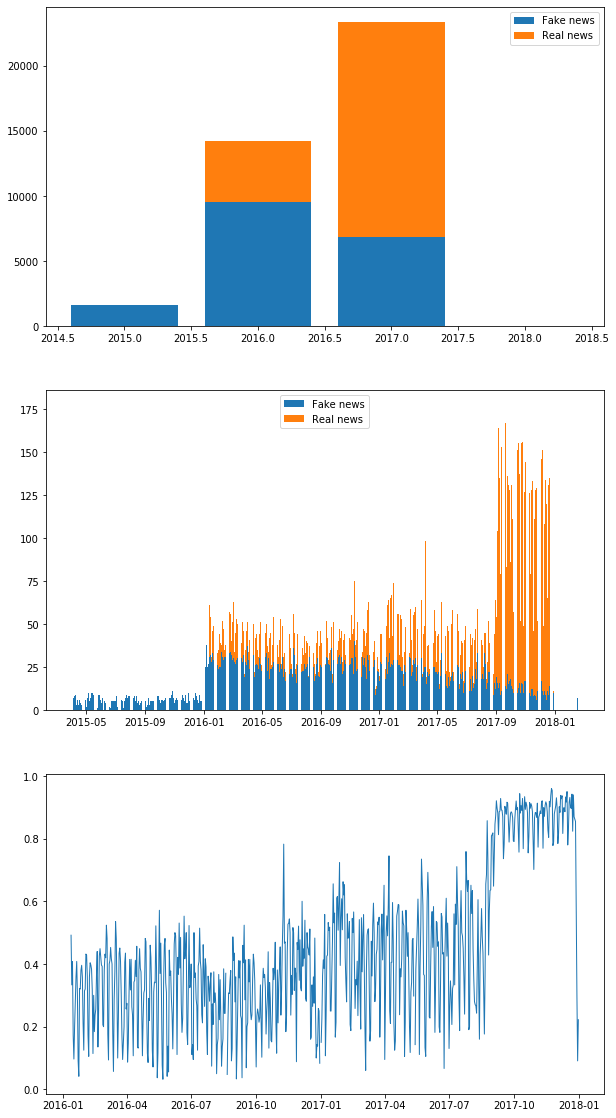

In [102]:
timeline=news_data[news_data['Datetime']!='1900-01-01 00:00:00'].groupby(['Datetime', 'IsFake']).size().unstack()
timeline['ProportionReal']=timeline[0]/(timeline[0]+timeline[1])
years=news_data[news_data['Datetime']!='1900-01-01 00:00:00'].groupby(['Year', 'IsFake']).size().unstack()

plt.figure(figsize=(10, 20))

plt.subplot(311)
plt.bar(years.index,years[1],width=0.8,label="Fake news")
plt.bar(years.index,years[0],width=0.8,bottom=years[1],label="Real news")
plt.legend()

plt.subplot(312)
plt.bar(timeline.index,timeline[1],width=0.8,label="Fake news")
plt.bar(timeline.index,timeline[0],width=0.8,bottom=timeline[1],label="Real news")
plt.legend()

plt.subplot(313)
plt.plot(timeline.index,timeline['ProportionReal'],linewidth=1.0)


We have articles from 2015-2017. However all our 2015 articles are just a relatively small subset of the fake news data, and the real news dataset is much more heavily sampled from 2017. 

It seems that the distribution over time is largely biased by the selections made for the two datasets, so we should be careful if we want to incorporate this into our model.

# Explorary data analysis - non-word features

Before going into word vectorisation,let's explore some features of the text and title (e.g. length, punctuation, upper case) that may be relevant. 

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'den

(0, 200)

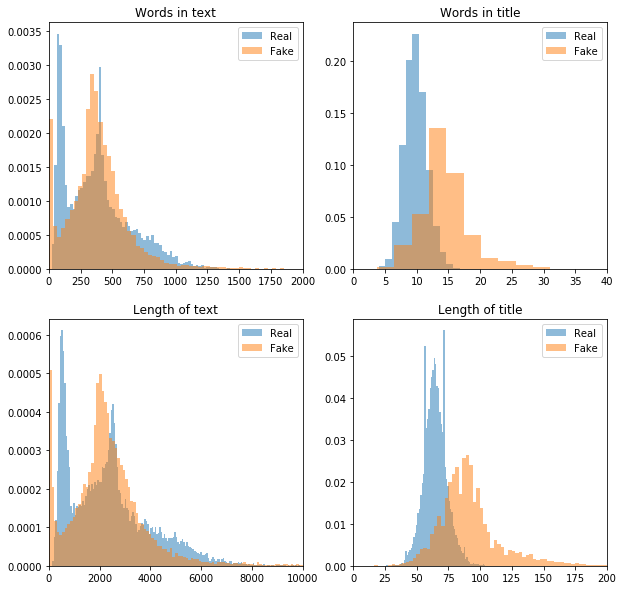

In [161]:
# Length in characters

news_data['titlelength'] = news_data['title'].apply(len)
news_data['textlength']  = news_data['text'].apply(len)

text_len_real = news_data[news_data["IsFake"] == 0]["textlength"]
text_len_fake = news_data[news_data["IsFake"] == 1]["textlength"]

title_len_real = news_data[news_data["IsFake"] == 0]["titlelength"]
title_len_fake = news_data[news_data["IsFake"] == 1]["titlelength"]


# Length in words
text_wordcount_real = news_data[news_data["IsFake"] == 0]["textlengthwords"]
text_wordcount_fake = news_data[news_data["IsFake"] == 1]["textlengthwords"]

title_wordcount_real = news_data[news_data["IsFake"] == 0]["titlelengthwords"]
title_wordcount_fake = news_data[news_data["IsFake"] == 1]["titlelengthwords"]


plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.hist(text_wordcount_real,alpha=0.5,bins=250,label="Real",normed=True)
plt.hist(text_wordcount_fake,alpha=0.5,bins=250,label="Fake",normed=True)
plt.title("Words in text")
plt.legend()
plt.xlim(0,2000)


plt.subplot(222)
plt.hist(title_wordcount_real,alpha=0.5,bins=15,label="Real",normed=True)
plt.hist(title_wordcount_fake,alpha=0.5,bins=15,label="Fake",normed=True)
plt.title("Words in title")
plt.legend()
plt.xlim(0,40)

plt.subplot(223)
plt.hist(text_len_real,alpha=0.5,bins=500,label="Real",normed=True)
plt.hist(text_len_fake,alpha=0.5,bins=500,label="Fake",normed=True)
plt.title("Length of text")
plt.legend()
plt.xlim(0,10000)


plt.subplot(224)
plt.hist(title_len_real,alpha=0.5,bins=100,label="Real",normed=True)
plt.hist(title_len_fake,alpha=0.5,bins=100,label="Fake",normed=True)
plt.title("Length of title")
plt.legend()
plt.xlim(0,200)

Fake and real news articles have significantly different distributions for both text and title length.

Fake news titles are on average longer and there is more variance in the distribution, whereas real news articles are much more narrowly distributed around 10 words/60 characters.

Both fake and real news articles have a bimodal distribution of text length - however the distribution of fake news seems to be more shifted to the left.

#### Counts of punctuation

In [23]:
def percent_punct(text):
    count=sum([1 for char in text if char in string.punctuation])
    textlength=len(text)-text.count(" ")
    if textlength>0:
        return count/textlength
    else:
        return 0

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


(0, 0.15)

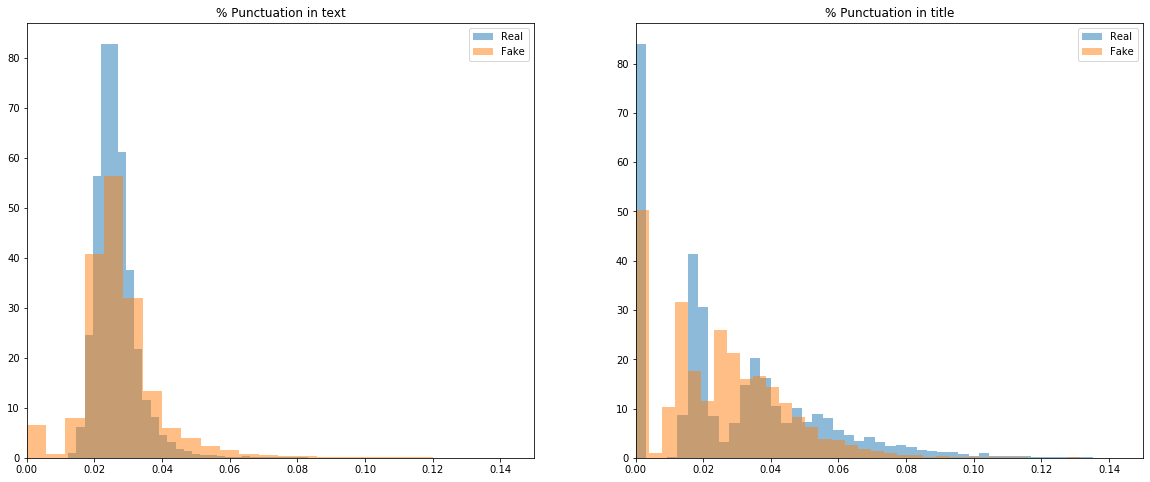

In [24]:
news_data["text_percent_punct"] = news_data["text"].apply(lambda x: percent_punct(x))
news_data["title_percent_punct"] = news_data["title"].apply(lambda x: percent_punct(x))

text_punct_real = news_data[news_data["IsFake"] == 0]["text_percent_punct"]
text_punct_fake = news_data[news_data["IsFake"] == 1]["text_percent_punct"]

title_punct_real = news_data[news_data["IsFake"] == 0]["title_percent_punct"]
title_punct_fake = news_data[news_data["IsFake"] == 1]["title_percent_punct"]


plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.hist(text_punct_real,alpha=0.5,bins=50,label="Real",normed=True)
plt.hist(text_punct_fake,alpha=0.5,bins=50,label="Fake",normed=True)
plt.title("% Punctuation in text")
plt.legend()
plt.xlim(0,0.15)

plt.subplot(122)
plt.hist(title_punct_real,alpha=0.5,bins=50,label="Real",normed=True)
plt.hist(title_punct_fake,alpha=0.5,bins=50,label="Fake",normed=True)
plt.title("% Punctuation in title")
plt.legend()
plt.xlim(0,0.15)

It doesn't appear that the frequency of punctuation in the text/title is particularly informative of whether a news article is fake or not.

However, the main punctuation mark most often found in the fake news set seems to be the exclamation mark, so we can try engineering a feature specifically around this.

In [25]:
def flag_exclamation(text):
    count=sum([1 for char in text if char=="!"])
    if count>0:
        return 1
    else:
        return 0

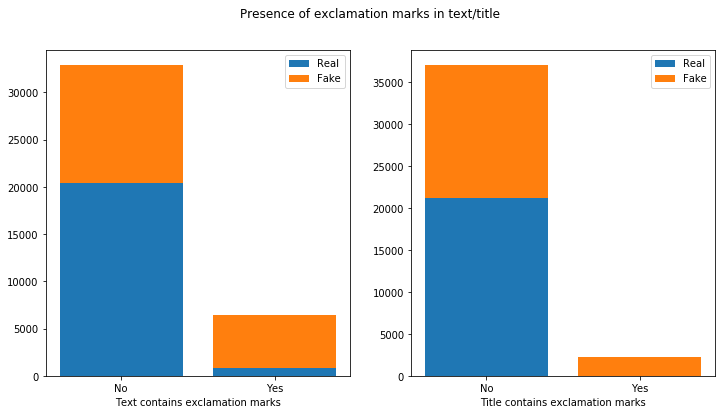

In [26]:
news_data["text_excl"] = news_data["text"].apply(lambda x: flag_exclamation(x))
news_data["title_excl"] = news_data["title"].apply(lambda x: flag_exclamation(x))

plt.figure(figsize=(12, 6))

plt.suptitle("Presence of exclamation marks in text/title")

plt.subplot(121)
plt.bar(["No","Yes"],
        news_data.groupby(['text_excl', 'IsFake']).size().unstack()[0],
        width=0.8,label="Real")
plt.bar(["No","Yes"],
        news_data.groupby(['text_excl', 'IsFake']).size().unstack()[1],
        bottom=news_data.groupby(['text_excl', 'IsFake']).size().unstack()[0],
        width=0.8,label="Fake")
plt.xlabel("Text contains exclamation marks")
plt.legend()


plt.subplot(122)
plt.bar(["No","Yes"],
        news_data.groupby(['title_excl', 'IsFake']).size().unstack()[0],
        width=0.8,label="Real")
plt.bar(["No","Yes"],
        news_data.groupby(['title_excl', 'IsFake']).size().unstack()[1],
        bottom=news_data.groupby(['title_excl', 'IsFake']).size().unstack()[0],
        width=0.8,label="Fake")
plt.xlabel("Title contains exclamation marks")
plt.legend()



Articles with an exclamation in the text are significantly more likely to be fake news, and articles with an exclamation in the title are exclusively fake news.

#### Capitalisation

A lot of the fake news article titles observed in the analysis above were in all caps - the proportion of the text that is capitalised may be an informative feature.
Note that this doesn't account for common abbreviations that would generally be capitalised anyway (such as USA, NYC, SCOTUS etc which we would expect to find in US politics news).

In [27]:
test="THIS SENTENCE IS half in uppercase"

def incapitals(text):
    wordsincaps=sum([1 for word in text.split() if word.isupper()==True])
    words=len(text.split())
    if words>0:
        return wordsincaps/words
    else:
        return 0
    
print(incapitals(test))

0.5


C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  from ipykernel import kernelapp as app
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


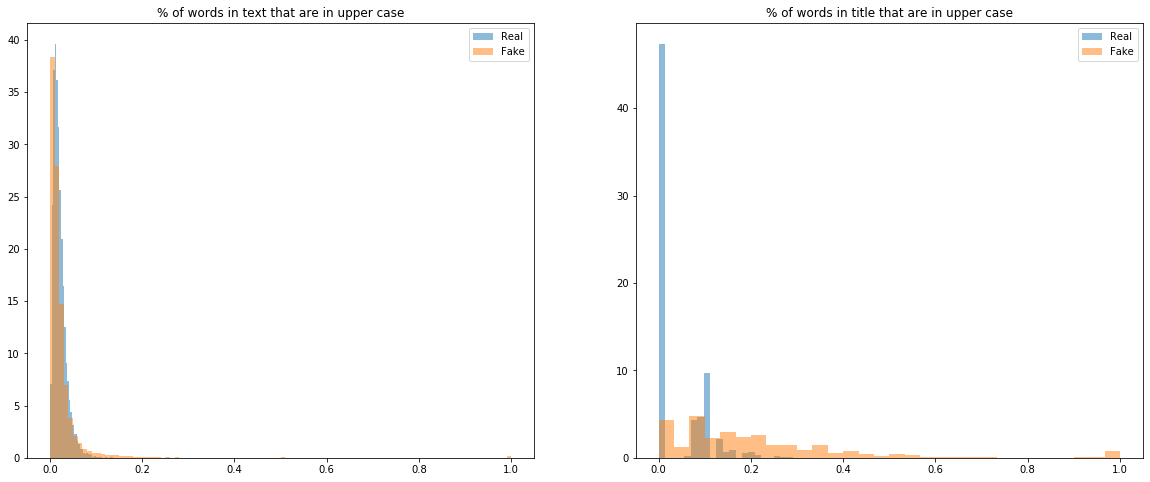

In [28]:
news_data["text_incaps"] = news_data["text"].apply(lambda x: incapitals(x))
news_data["title_incaps"] = news_data["title"].apply(lambda x: incapitals(x))

text_incaps_real = news_data[news_data["IsFake"] == 0]["text_incaps"]
text_incaps_fake = news_data[news_data["IsFake"] == 1]["text_incaps"]

title_incaps_real = news_data[news_data["IsFake"] == 0]["title_incaps"]
title_incaps_fake = news_data[news_data["IsFake"] == 1]["title_incaps"]


plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.hist(text_incaps_real,alpha=0.5,bins=100,label="Real",normed=True)
plt.hist(text_incaps_fake,alpha=0.5,bins=100,label="Fake",normed=True)
plt.title("% of words in text that are in upper case")
plt.legend()
#plt.xlim(0,0.15)

plt.subplot(122)
plt.hist(title_incaps_real,alpha=0.5,bins=30,label="Real",normed=True)
plt.hist(title_incaps_fake,alpha=0.5,bins=30,label="Fake",normed=True)
plt.title("% of words in title that are in upper case")
plt.legend()
#plt.xlim(0,0.15)

# Exploratory data analysis - word features

We will combine the article title and text into one in order to construct the word corpus

In [29]:
news_data['news']=news_data['title']+news_data['text']
news_data.head()

,title,text,subject,date,IsFake,textlengthwords,titlelengthwords,VideoStoryOrLink,Datetime,Year,titlelength,textlength,text_percent_punct,title_percent_punct,text_excl,title_excl,text_incaps,title_incaps,news
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,749,10,0,2017-12-31,2017,64,4659,0.030202,0.054545,0,0,0.016021,0.100000,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,624,9,0,2017-12-29,2017,64,4077,0.022299,0.053571,0,0,0.011218,0.111111,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,457,10,0,2017-12-31,2017,60,2789,0.020224,0.117647,0,0,0.015317,0.100000,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,376,9,0,2017-12-30,2017,59,2461,0.024460,0.039216,0,0,0.010638,0.222222,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,852,11,0,2017-12-29,2017,69,5204,0.031329,0.033898,1,0,0.017606,0.000000,Trump wants Postal Service to charge 'much mor...


#### Most common words

Pick top 30 most frequent words across all the articles.

In [238]:
fake_news_topwords=pd.Series(' '.join(news_data[news_data['IsFake']==1]['text']).split()).value_counts()[:30]
real_news_topwords=pd.Series(' '.join(news_data[news_data['IsFake']==0]['text']).split()).value_counts()[:30]

Text(0.5, 1.0, 'Frequency in real news articles')

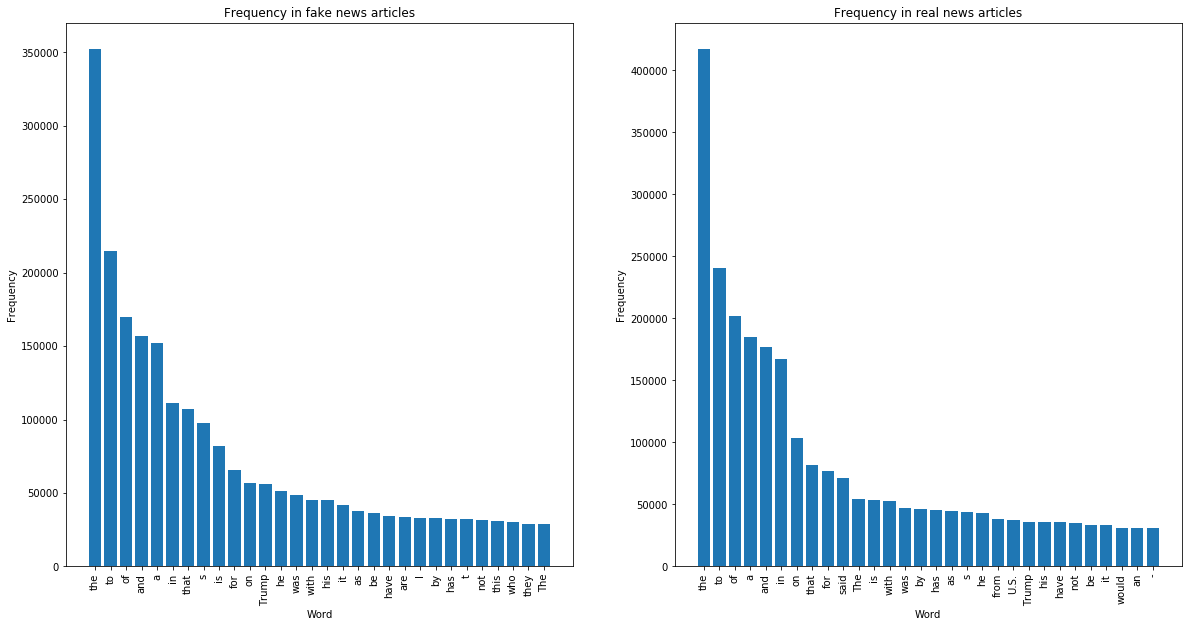

In [252]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.bar(fake_news_topwords.index, fake_news_topwords.values)
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency in fake news articles')

plt.subplot(122)
plt.bar(real_news_topwords.index, real_news_topwords.values)
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency in real news articles')

At the minute the top words are all nearly all just common 'stop words', which are always going to feature frequently in any English text and do not really add much meaning/context. 

We're also seeing duplicates with different capitalisation (e.g. The/the) .

We need to 'clean' the text to remove these common words and standardize the text to lower case.

In [87]:
stopwordslist = stopwords.words('english')

def clean_text(text):
    text="".join([letter for letter in text if letter not in string.punctuation])
    tokens=re.split('\W+',text)
    output_text=" ".join([word.lower() for word in tokens if word.lower() not in stopwordslist])
    return output_text

In [88]:
news_data['news_clean']=news_data['news'].apply(lambda x: clean_text(x))

In [89]:
fake_news_topwords=pd.Series(' '.join(news_data[news_data['IsFake']==1]['news_clean']).split()).value_counts()[:30]
real_news_topwords=pd.Series(' '.join(news_data[news_data['IsFake']==0]['news_clean']).split()).value_counts()[:30]

Text(0.5, 1.0, 'Frequency in real news articles')

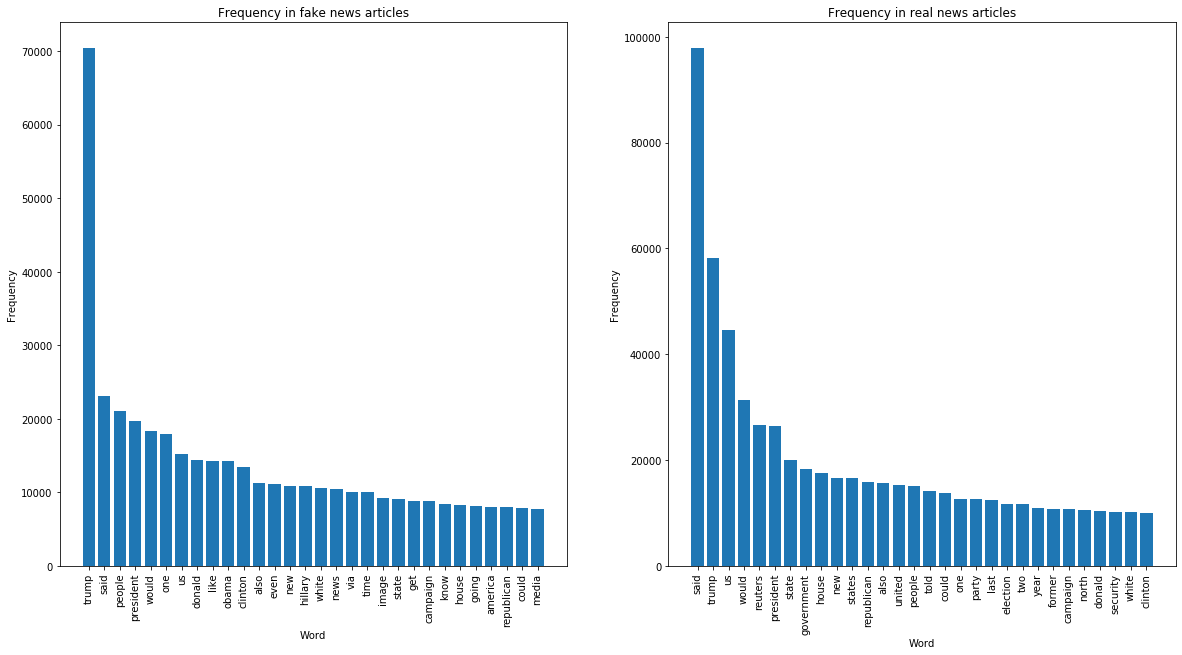

In [90]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.bar(fake_news_topwords.index, fake_news_topwords.values)
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency in fake news articles')

plt.subplot(122)
plt.bar(real_news_topwords.index, real_news_topwords.values)
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency in real news articles')

The top words now are a much better representation of the topics frequently being discussed (i.e. US politics).

# Model using word features

We'll first try creating an NLP model built from the text & title of the articles.

In [91]:
X = news_data['news_clean']
y = news_data['IsFake']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=101)

#### Using simple count vectoriser

In [92]:
cv_text = CountVectorizer()
X_train_vect = cv_text.fit_transform(X_train)
X_test_vect=cv_text.transform(X_test)

# Naive-Bayes Model
naivebayes = MultinomialNB()
naivebayes.fit(X_train_vect,y_train)

# Random Forest Model
rf=RandomForestClassifier()
rf.fit(X_train_vect,y_train)


#Confusion matrices
cm_train_nb = confusion_matrix(y_train, naivebayes.predict(X_train_vect) , labels=[0, 1])
cm_train_rf = confusion_matrix(y_train, rf.predict(X_train_vect) , labels=[0, 1])
cm_test_nb = confusion_matrix(y_test, naivebayes.predict(X_test_vect) , labels=[0, 1])
cm_test_rf = confusion_matrix(y_test, rf.predict(X_test_vect) , labels=[0, 1])

Text(0.5, 1, 'Random Forest (test set) - accuracy 0.972')

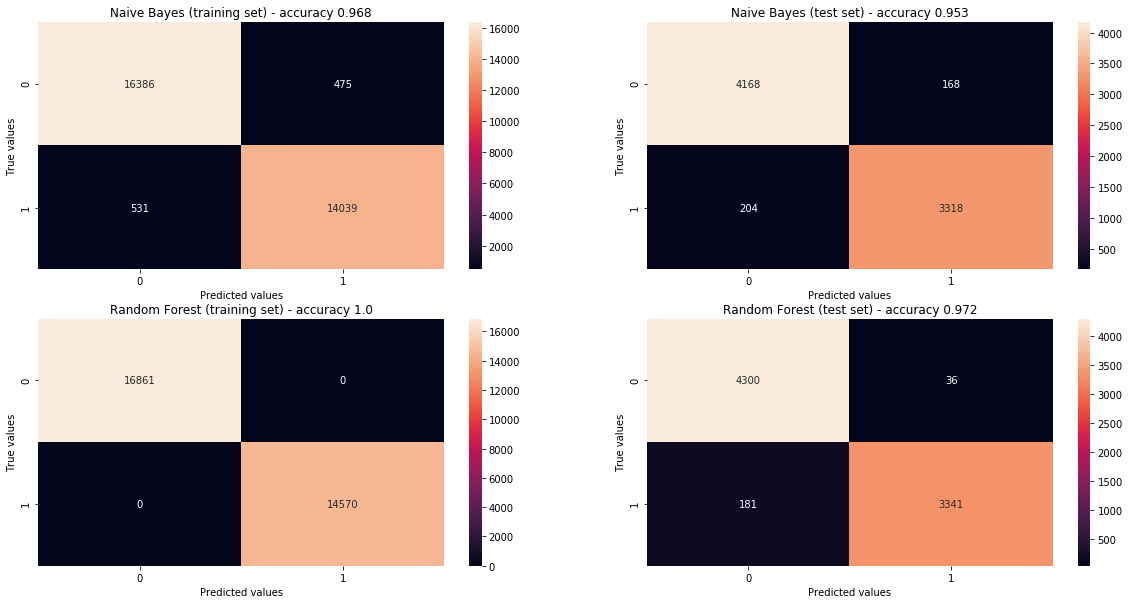

In [93]:
plt.figure(figsize=(20,10))

plt.subplot(221)
sns.heatmap(cm_train_nb, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Naive Bayes (training set) - accuracy '+str(round(accuracy_score(y_train,naivebayes.predict(X_train_vect)),3)))

plt.subplot(222)
sns.heatmap(cm_test_nb, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Naive Bayes (test set) - accuracy '+str(round(accuracy_score(y_test,naivebayes.predict(X_test_vect)),3)))

plt.subplot(223)
sns.heatmap(cm_train_rf, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (training set) - accuracy '+str(round(accuracy_score(y_train,rf.predict(X_train_vect)),3)))

plt.subplot(224)
sns.heatmap(cm_test_rf, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (test set) - accuracy '+str(round(accuracy_score(y_test,rf.predict(X_test_vect)),3)))

Both NB and RF models appear to perform extremely well (with a high degree of accuracy) random forest appears to perform slightly better on the test set however.

#### Using TFIDF Vectoriser

Try using a TFIDF vectoriser, which weights words according to their frequency in the article as well as accounting for their frequency in the overall set of articles. This may be able to improve performance even further.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
tfidf_vect = TfidfVectorizer()
X_train_vect = tfidf_vect.fit_transform(X_train)
X_test_vect=tfidf_vect.transform(X_test)

# Naive-Bayes Model
naivebayes = MultinomialNB()
naivebayes.fit(X_train_vect,y_train)

# Random Forest Model
rf=RandomForestClassifier()
rf.fit(X_train_vect,y_train)


#Confusion matrices
cm_train_nb = confusion_matrix(y_train, naivebayes.predict(X_train_vect) , labels=[0, 1])
cm_train_rf = confusion_matrix(y_train, rf.predict(X_train_vect) , labels=[0, 1])
cm_test_nb = confusion_matrix(y_test, naivebayes.predict(X_test_vect) , labels=[0, 1])
cm_test_rf = confusion_matrix(y_test, rf.predict(X_test_vect) , labels=[0, 1])

Text(0.5, 1, 'Random Forest (test set) - accuracy 0.976')

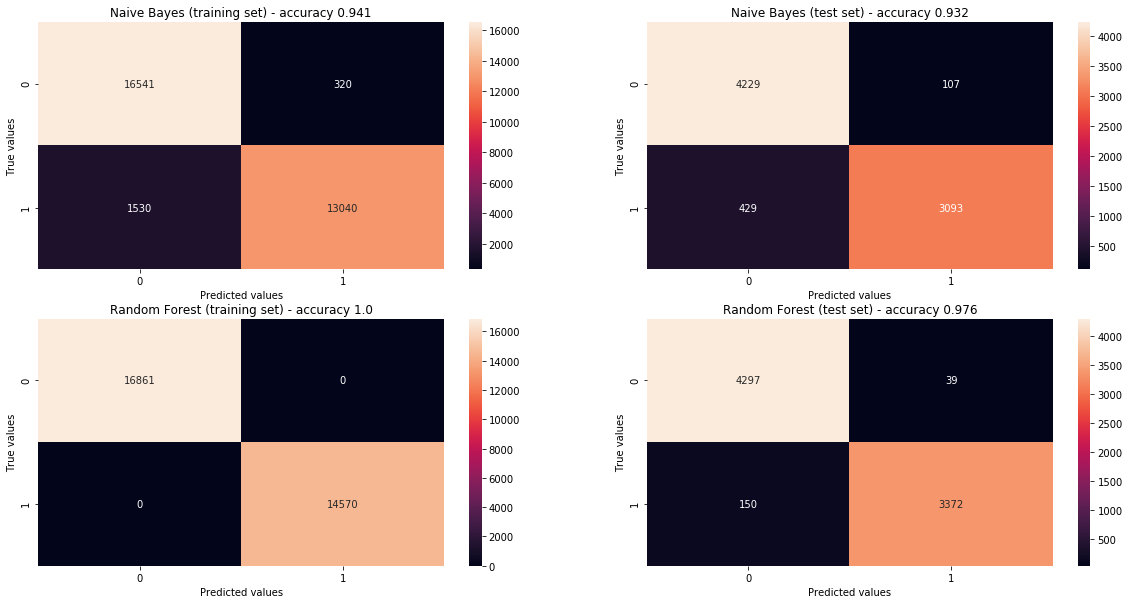

In [53]:
plt.figure(figsize=(20,10))

plt.subplot(221)
sns.heatmap(cm_train_nb, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Naive Bayes (training set) - accuracy '+str(round(accuracy_score(y_train,naivebayes.predict(X_train_vect)),3)))

plt.subplot(222)
sns.heatmap(cm_test_nb, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Naive Bayes (test set) - accuracy '+str(round(accuracy_score(y_test,naivebayes.predict(X_test_vect)),3)))

plt.subplot(223)
sns.heatmap(cm_train_rf, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (training set) - accuracy '+str(round(accuracy_score(y_train,rf.predict(X_train_vect)),3)))

plt.subplot(224)
sns.heatmap(cm_test_rf, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (test set) - accuracy '+str(round(accuracy_score(y_test,rf.predict(X_test_vect)),3)))

The TFIDF vectoriser seems to slightly worsen the performance of the Naive-Bayes model, although appears to give a marginally better accuracy for random forest.

#### Feature importance

Take top 50 most important features of the random forest model.

In [94]:
rf_feature_importances=pd.Series(rf.feature_importances_, index=tfidf_vect.get_feature_names()).sort_values(ascending=False)[:50]

Text(0.5, 1.0, 'Feature importance')

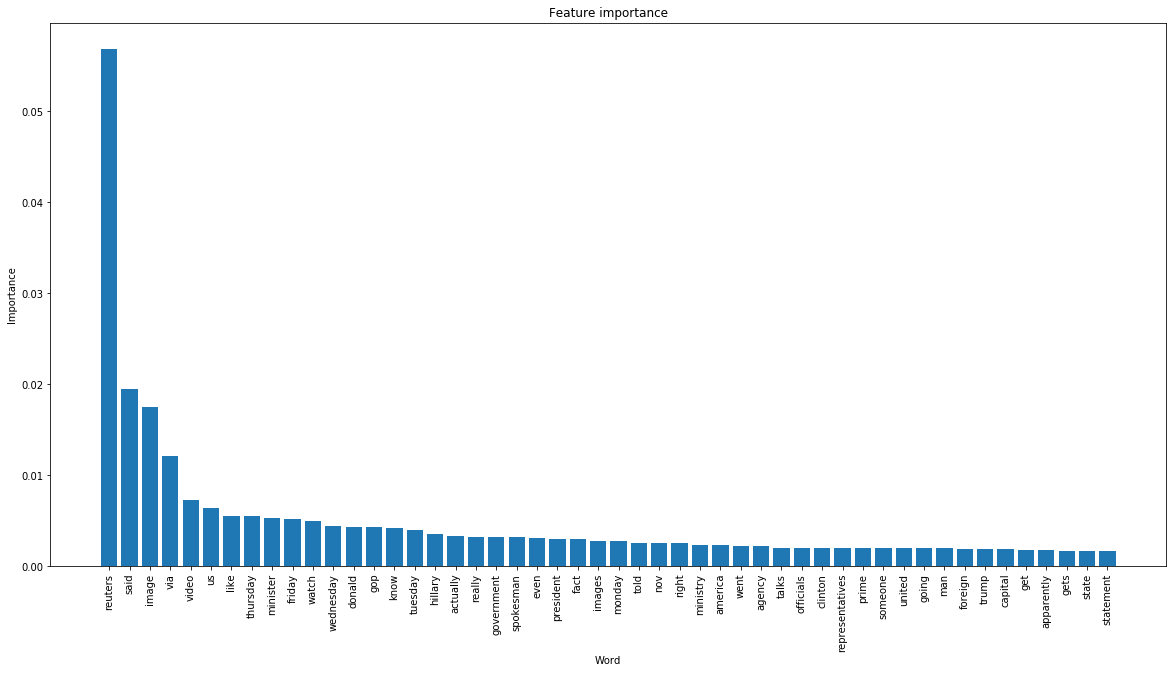

In [95]:
plt.figure(figsize=(20,10))

plt.bar(rf_feature_importances.index, rf_feature_importances.values)
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Importance')
plt.title('Feature importance')


The first thing we notice is that the most important feature/word in the model is 'reuters' - going back and looking at the initial data we see that many articles from the real news dataset begin by stating Reuters as the source of publication. 

As a result almost all the articles containing the word 'Reuters' are real - hence the model is learning that the presence of the word is a strong predictor of the news article being genuine.

In [99]:
reuters=news_data[news_data['text'].str.lower().str.contains('reuters')]
display(reuters['IsFake'].value_counts())
reuters.head()

0    21159
1      220
Name: IsFake, dtype: int64

,title,text,subject,date,IsFake,textlengthwords,titlelengthwords,VideoStoryOrLink,Datetime,Year,titlelength,textlength,text_percent_punct,title_percent_punct,text_excl,title_excl,text_incaps,title_incaps,news,news_clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,749,10,0,2017-12-31,2017,64,4659,0.030202,0.054545,0,0,0.016021,0.100000,"As U.S. budget fight looms, Republicans flip t...",us budget fight looms republicans flip fiscal ...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,624,9,0,2017-12-29,2017,64,4077,0.022299,0.053571,0,0,0.011218,0.111111,U.S. military to accept transgender recruits o...,us military accept transgender recruits monday...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,457,10,0,2017-12-31,2017,60,2789,0.020224,0.117647,0,0,0.015317,0.100000,Senior U.S. Republican senator: 'Let Mr. Muell...,senior us republican senator let mr mueller jo...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,376,9,0,2017-12-30,2017,59,2461,0.024460,0.039216,0,0,0.010638,0.222222,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped australian diplomat ti...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,852,11,0,2017-12-29,2017,69,5204,0.031329,0.033898,1,0,0.017606,0.000000,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge much amazon ...


It isn't particularly desirable for our model to have learnt this as the most important word/feature in predicting whether an article is real news. It is really just a result of how the genuine articles have been sampled that the publisher appears named as the source in the text, rather than a feature of how the article text itself is written. 

Let's try removing 'Reuters' from the corpus and see if we still get a good model performance.

In [101]:
def clean_text2(text):
    text="".join([letter for letter in text if letter not in string.punctuation])
    tokens=re.split('\W+',text)
    output_text=" ".join([word.lower() for word in tokens if word.lower() not in stopwordslist and word.lower()!='reuters'])
    return output_text

In [102]:
news_data['news_clean']=news_data['news'].apply(lambda x: clean_text2(x))

In [103]:
X = news_data['news_clean']
y = news_data['IsFake']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=101)

In [104]:
tfidf_vect = TfidfVectorizer()
X_train_vect = tfidf_vect.fit_transform(X_train)
X_test_vect=tfidf_vect.transform(X_test)

# Random Forest Model
rf=RandomForestClassifier()
rf.fit(X_train_vect,y_train)

#Confusion matrices
cm_train_rf = confusion_matrix(y_train, rf.predict(X_train_vect) , labels=[0, 1])
cm_test_rf = confusion_matrix(y_test, rf.predict(X_test_vect) , labels=[0, 1])

Text(0.5, 1, 'Random Forest (test set) - accuracy 0.964')

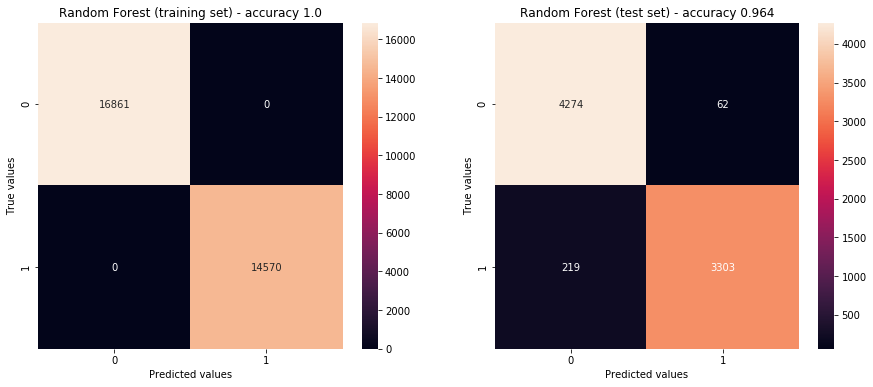

In [109]:
plt.figure(figsize=(15,6))


plt.subplot(121)
sns.heatmap(cm_train_rf, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (training set) - accuracy '+str(round(accuracy_score(y_train,rf.predict(X_train_vect)),3)))

plt.subplot(122)
sns.heatmap(cm_test_rf, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (test set) - accuracy '+str(round(accuracy_score(y_test,rf.predict(X_test_vect)),3)))

Fortunately it seems we don't lose very much accuracy from taking 'Reuters' out of the corpus.

## Model using non-word features

Try training an alternative model using the auxiliary features we have engineered.

In [110]:
X = news_data[['titlelength','textlength','title_excl','text_excl','title_incaps','VideoStoryOrLink']]
y = news_data['IsFake']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=101)
X_train.head()

,titlelength,textlength,title_excl,text_excl,title_incaps,VideoStoryOrLink
4986,66,2512,0,0,0.000000,0
7799,78,2758,0,0,0.090909,0
6146,60,3903,0,0,0.181818,0
11424,102,264,0,1,0.388889,0
22863,72,1058,0,0,0.100000,0


Scale the variables

In [111]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),columns=X_test.columns)


X_train_scaled.head()

,titlelength,textlength,title_excl,text_excl,title_incaps,VideoStoryOrLink
0,-0.489078,0.049343,-0.243991,-0.440100,-0.696141,-0.123076
1,0.043705,0.176267,-0.243991,-0.440100,-0.141182,-0.123076
2,-0.755469,0.767032,-0.243991,-0.440100,0.413777,-0.123076
3,1.109271,-1.110515,-0.243991,2.272211,1.677850,-0.123076
4,-0.222686,-0.700850,-0.243991,-0.440100,-0.085686,-0.123076


We'll try training a logistic regression as well as another random forest model

In [112]:

# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
lrmodel = LogisticRegression()
lrmodel.fit(X_train_scaled, y_train)

# Random Forest Model
rf=RandomForestClassifier()
rf.fit(X_train_scaled,y_train)


#Confusion matrices
cm_train_nb = confusion_matrix(y_train, lrmodel.predict(X_train_scaled) , labels=[0, 1])
cm_train_rf = confusion_matrix(y_train, rf.predict(X_train_scaled) , labels=[0, 1])
cm_test_nb = confusion_matrix(y_test, lrmodel.predict(X_test_scaled) , labels=[0, 1])
cm_test_rf = confusion_matrix(y_test, rf.predict(X_test_scaled) , labels=[0, 1])

Text(0.5, 1, 'Random Forest (test set) - accuracy 0.9')

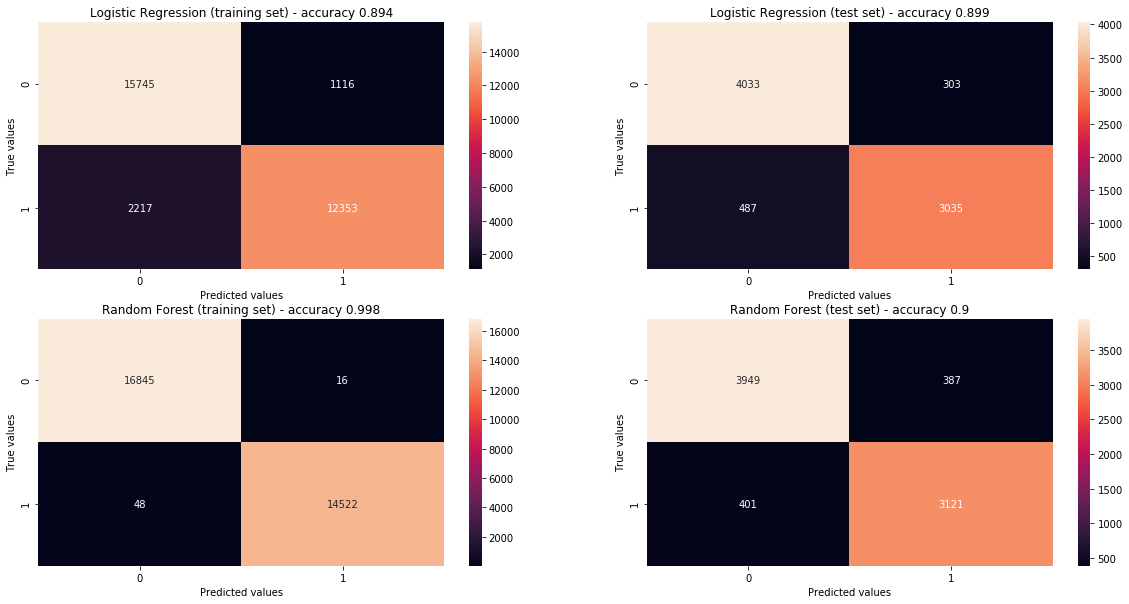

In [59]:
plt.figure(figsize=(20,10))

plt.subplot(221)
sns.heatmap(cm_train_nb, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Logistic Regression (training set) - accuracy '+str(round(accuracy_score(y_train,lrmodel.predict(X_train_scaled)),3)))

plt.subplot(222)
sns.heatmap(cm_test_nb, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Logistic Regression (test set) - accuracy '+str(round(accuracy_score(y_test,lrmodel.predict(X_test_scaled)),3)))

plt.subplot(223)
sns.heatmap(cm_train_rf, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (training set) - accuracy '+str(round(accuracy_score(y_train,rf.predict(X_train_scaled)),3)))

plt.subplot(224)
sns.heatmap(cm_test_rf, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (test set) - accuracy '+str(round(accuracy_score(y_test,rf.predict(X_test_scaled)),3)))

The model trained on just the auxiliary features also seems to do very well. It may be that we can combine the text/extra feature models to predict a final output that is more accurate (i.e. if one model picks up on fake news cases that the other hasn't detected  as well).

#### Train both types of models

In [115]:
X = news_data[['news_clean','titlelength','textlength','title_excl','text_excl','title_incaps','VideoStoryOrLink']]
y = news_data['IsFake']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=101)

#-----------Train model on text-------------------------------------------------------
X_train_text=X_train['news_clean']
X_test_text=X_test['news_clean']

tfidf_vect = TfidfVectorizer()
X_train_vect = tfidf_vect.fit_transform(X_train_text)
X_test_vect=tfidf_vect.transform(X_test_text)


rf_text=RandomForestClassifier()
rf_text.fit(X_train_vect,y_train)

#-----------Train model on extra features-------------------------------------------------------

X_train_extra=X_train.drop('news_clean',axis=1)
X_test_extra=X_test.drop('news_clean',axis=1)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_extra.values),columns=X_train_extra.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_extra.values),columns=X_test_extra.columns)


rf_extra=RandomForestClassifier()
rf_extra.fit(X_train_scaled,y_train)

RandomForestClassifier()

To combine the models we'll look at the raw predicted probabilities they generate, and try to set thresholds based on both of these for when an article should be flagged as fake news. For instance - if the text model gives a 50-60% likelihood of being fake whilst the extra features model says 20-30%, is this article more likely to be real?

The function below will 'floor' the probability score down to 1 decimal place (creating aggregated score bands i.e 0-0.1, 0.1-0.2 etc)

In [135]:
test=0.6993

def decimal(x):
    return math.floor(x*10) / 10

decimal(test)

0.6

In [136]:
train_scores=pd.DataFrame({"TextScore" : rf_text.predict_proba(X_train_vect)[:, 1] ,
                           "ExtraScore": rf_extra.predict_proba(X_train_scaled)[:, 1],
                           "IsFake": y_train})
test_scores=pd.DataFrame({"TextScore" : rf_text.predict_proba(X_test_vect)[:, 1] ,
                           "ExtraScore": rf_extra.predict_proba(X_test_scaled)[:, 1],
                           "IsFake": y_test})

train_scores['TextScore_group']=train_scores['TextScore'].apply(lambda x: decimal(x))
train_scores['ExtraScore_group']=train_scores['ExtraScore'].apply(lambda x: decimal(x))
test_scores['TextScore_group']=test_scores['TextScore'].apply(lambda x: decimal(x))
test_scores['ExtraScore_group']=test_scores['ExtraScore'].apply(lambda x: decimal(x))


train_predict=pd.DataFrame({"TextPred" : rf_text.predict(X_train_vect),
                           "ExtraPred": rf_extra.predict(X_train_scaled),
                           "IsFake": y_train})
test_predict=pd.DataFrame({"TextPred" : rf_text.predict(X_test_vect),
                           "ExtraPred": rf_extra.predict(X_test_scaled),
                           "IsFake": y_test})


Compare the banded predicted probabilities from each model, and what percentage in each segment is actually fake news.

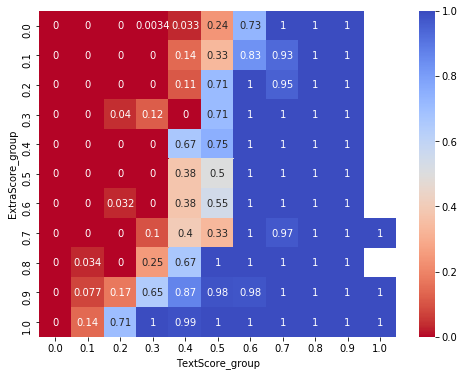

In [147]:
comparemodeltest=test_scores.groupby(['TextScore_group','ExtraScore_group']).mean()[['IsFake']].reset_index()
comparemodeltest=comparemodeltest.pivot(index='ExtraScore_group',columns='TextScore_group',values='IsFake')

plt.figure(figsize=(8, 6))
sns.heatmap(comparemodeltest, cmap='coolwarm_r', annot=True, annot_kws={'size':10})

As we saw earlier the text model is the more accurate of the two models, and splits most of the articles correctly into real/fake news.

However there are subpopulations where either:
- The text model gives a weak prediction of the article being fake, whereas the extra features model gives a stronger prediction that it is genuine. 
- The text model gives a weak prediction of the article being genuine, whereas the extra features model gives a stronger prediction that it is fake. 

It seems for some of these segments the extra features model is more often accurate than the text model. 

For instance we observe the following:
- When the text model predicts a 50-60% probability of the article being fake, but the extra features model score is 0-20% the article is **genuine** news the majority of the time.
- When the text model predicts a 40-50% probability of the article being fake (50-60% probability of being genuine), but the extra features model score is >80% the article is **fake** news the majority of the time.
- When the text model predicts a 30-40% probability of the article being fake (60-70% probability of being genuine), but the extra features model score is >90% the article is **fake** news the majority of the time.
- When the text model predicts a 20-30% probability of the article being fake (70-80% probability of being genuine), but the extra features model score is 1 the article is **fake** news the majority of the time.

We will encode these thresholds based on the model scores in the function below to see if it improves performance.

In [157]:
def finalpredict(scoretext,scoreextra):
    if scoretext>=0.6:
        finalpred=1
    elif scoretext>=0.5:
        if scoreextra>=0.2:
            finalpred=1
        else:
            finalpred=0
    elif scoretext>=0.4:
        if scoreextra>=0.8:
            finalpred=1
        else:
            finalpred=0
    elif scoretext>=0.3:
        if scoreextra>=0.9:
            finalpred=1
        else:
            finalpred=0
    elif scoretext>=0.2:
        if scoreextra==1.0:
            finalpred=1
        else:
            finalpred=0
    else:
        finalpred=0
    return finalpred

Text(0.5, 1, 'Random Forest (test set) - accuracy 0.988')

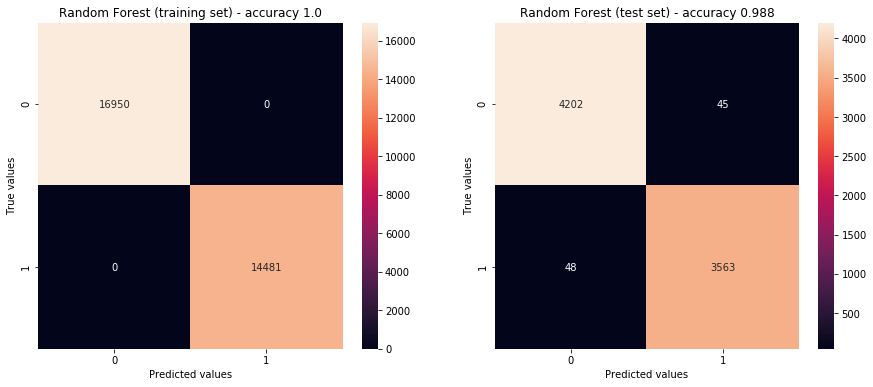

In [158]:
X = news_data[['news_clean','titlelength','textlength','title_excl','text_excl','title_incaps','VideoStoryOrLink']]
y = news_data['IsFake']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

#-----------Train model on text-------------------------------------------------------
X_train_text=X_train['news_clean']
X_test_text=X_test['news_clean']

tfidf_vect = TfidfVectorizer()
X_train_vect = tfidf_vect.fit_transform(X_train_text)
X_test_vect=tfidf_vect.transform(X_test_text)


rf_text=RandomForestClassifier()
rf_text.fit(X_train_vect,y_train)

#-----------Train model on extra features-------------------------------------------------------

X_train_extra=X_train.drop('news_clean',axis=1)
X_test_extra=X_test.drop('news_clean',axis=1)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_extra.values),columns=X_train_extra.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_extra.values),columns=X_test_extra.columns)


rf_extra=RandomForestClassifier()
rf_extra.fit(X_train_scaled,y_train)


#---------------Combine scores------------------------------------

train_scores=pd.DataFrame({"TextScore" : rf_text.predict_proba(X_train_vect)[:, 1] ,
                           "ExtraScore": rf_extra.predict_proba(X_train_scaled)[:, 1]})
test_scores=pd.DataFrame({"TextScore" : rf_text.predict_proba(X_test_vect)[:, 1] ,
                           "ExtraScore": rf_extra.predict_proba(X_test_scaled)[:, 1]})

train_scores['FinalPred'] = train_scores.apply(lambda x: finalpredict(x['TextScore'],x['ExtraScore']),axis=1)
test_scores['FinalPred'] = test_scores.apply(lambda x: finalpredict(x['TextScore'],x['ExtraScore']),axis=1)


cm_train = confusion_matrix(y_train, train_scores['FinalPred'] , labels=[0, 1])
cm_test = confusion_matrix(y_test, test_scores['FinalPred'] , labels=[0, 1])


#---------------Results------------------------------------

plt.figure(figsize=(15,6))


plt.subplot(121)
sns.heatmap(cm_train, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (training set) - accuracy '+str(round(accuracy_score(y_train,train_scores['FinalPred']),3)))

plt.subplot(122)
sns.heatmap(cm_test, annot=True,fmt='g')
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Random Forest (test set) - accuracy '+str(round(accuracy_score(y_test,test_scores['FinalPred']),3)))

We have added incremental value by being able to improve the accuracy by 2.4%! Our combined model now has an accuracy of 98.8% which is a significant improvement.